<a href="https://colab.research.google.com/github/vtecftwy/fastbook/blob/walk-thru/04_mnist_full_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Full Dataset
Model to classify MNIST for unpackAI Bootcamp 2: first session

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 17.8MB/s 
     |████████████████████████████████| 51kB 9.7MB/s 
     |████████████████████████████████| 194kB 62.1MB/s 
     |████████████████████████████████| 1.1MB 60.5MB/s 
     |████████████████████████████████| 61kB 10.2MB/s 
Mounted at /content/gdrive


In [2]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

## Load MNIST data and create dataloaders

In [3]:
path = untar_data(URLs.MNIST)
path.ls(),  (path/'training').ls(), (path/'testing').ls()

((#2) [Path('/root/.fastai/data/mnist_png/testing'),Path('/root/.fastai/data/mnist_png/training')],
 (#10) [Path('/root/.fastai/data/mnist_png/training/3'),Path('/root/.fastai/data/mnist_png/training/1'),Path('/root/.fastai/data/mnist_png/training/0'),Path('/root/.fastai/data/mnist_png/training/9'),Path('/root/.fastai/data/mnist_png/training/6'),Path('/root/.fastai/data/mnist_png/training/2'),Path('/root/.fastai/data/mnist_png/training/8'),Path('/root/.fastai/data/mnist_png/training/5'),Path('/root/.fastai/data/mnist_png/training/7'),Path('/root/.fastai/data/mnist_png/training/4')],
 (#10) [Path('/root/.fastai/data/mnist_png/testing/3'),Path('/root/.fastai/data/mnist_png/testing/1'),Path('/root/.fastai/data/mnist_png/testing/0'),Path('/root/.fastai/data/mnist_png/testing/9'),Path('/root/.fastai/data/mnist_png/testing/6'),Path('/root/.fastai/data/mnist_png/testing/2'),Path('/root/.fastai/data/mnist_png/testing/8'),Path('/root/.fastai/data/mnist_png/testing/5'),Path('/root/.fastai/data/m

Folder structure: 

```
path
   |- training
         |- 0 : all images of 0
         |- 1 : all images of 1
         |- . . . 
         |- 9 : all images of 9
   |- testing
         |- 0 : all images of 0
         |- 1 : all images of 1
         |- . . . 
         |- 9 : all images of 9
```

Elements to create the DataBlocks:
- `blocks`: 
    - `ImageBlock`. But MNIST images are BW, so we also pass the cls `PILImageBW`
    - `CategoryBlock`
- `get_items`: `get_image_files` method to get the list of all image files in the folder
- `get_y`: `parent_label` as images are grouped be folder/category
- `splitter`: `RamdomSplitter` because this dataset only includes a training folder and a testing folder, no validation folder.

Augmentation: exclude flipping and cropping

In [4]:
# rotation = Rotate(max_deg=30, p=0.5, draw=None, size=None, mode='bilinear', pad_mode='reflection', align_corners=True, batch=False)

augmentation = aug_transforms(mult=1.0, 
                              do_flip=False, 
                              flip_vert=False, 
                              max_rotate=15.0, 
                              min_zoom=0.66, 
                              max_zoom=1.0, 
                              max_lighting=0.3, 
                              max_warp=0, 
                              p_affine=0.75, 
                              p_lighting=0.75, 
                              xtra_tfms=None, 
                              size=None, 
                              mode='bilinear',
                            #   mode='nearest',
                              pad_mode='border', # 'zeros', 'border', 'reflection'
                              align_corners=True, 
                              batch=False, 
                              min_scale=1.0)

In [5]:
dblock = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   splitter=RandomSplitter(seed=1988),
                   batch_tfms=augmentation
                   )

In [6]:
dls = dblock.dataloaders(path/'training', bs=256)

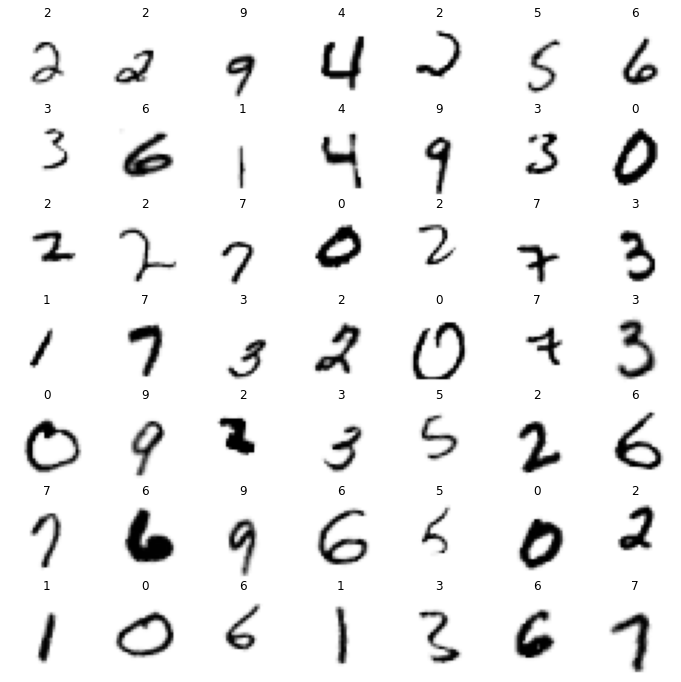

In [7]:
dls.show_batch(max_n=49, figsize=(12,12))

In [8]:
dls.vocab

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [ ]:
# dblock.summary(path)

## Define Testset dataloader and metrics

In [9]:
dblock_tst = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
                      get_items=get_image_files,
                      get_y=parent_label
                      )

In [10]:
test_dls = dblock_tst.dataloaders(path/'testing')
test_dl = dls.test_dl(test_items=test_dls.items, with_labels=True)

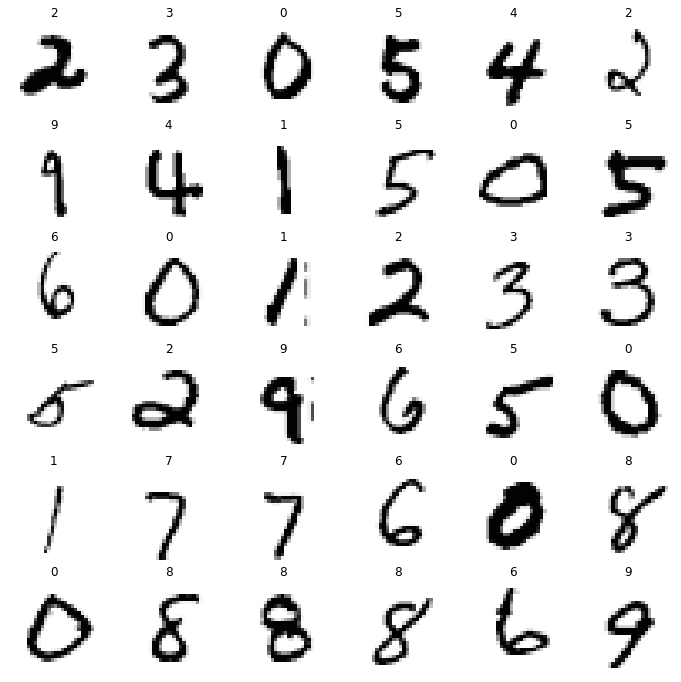

In [11]:
test_dls.show_batch(max_n=36, figsize=(12,12))

In [12]:
precision = Precision(average='macro')
recall = Recall(average='macro')

## Resnet 18  Pretrained

In [14]:
learn_18 = cnn_learner(dls, resnet18, metrics=[error_rate, accuracy, precision, recall], pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.05754399299621582)

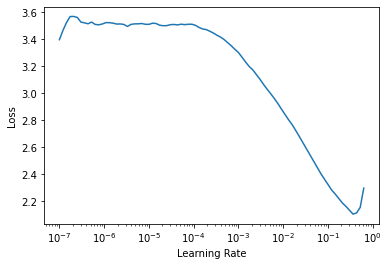

In [15]:
learn_18.lr_find()

In [16]:
n = 16
lr = 1e-2
learn_18.fit_one_cycle(n_epoch=n, lr_max=lr)

epoch,train_loss,valid_loss,error_rate,accuracy,precision_score,recall_score,time
0,0.835397,0.358255,0.102417,0.897583,0.897395,0.896208,00:49
1,0.274811,0.151284,0.046750,0.953250,0.953806,0.953223,00:48
2,0.175835,0.101323,0.027167,0.972833,0.972876,0.972542,00:48
3,0.144378,0.087751,0.024917,0.975083,0.975425,0.974840,00:48
4,0.122687,0.104707,0.029083,0.970917,0.972184,0.970743,00:48
5,0.099749,0.095751,0.028250,0.971750,0.972646,0.971273,00:48
6,0.091629,0.063423,0.018333,0.981667,0.981927,0.981546,00:48
7,0.084011,0.043866,0.013917,0.986083,0.986035,0.985970,00:48
8,0.072259,0.048133,0.013417,0.986583,0.986666,0.986483,00:48
9,0.060650,0.044016,0.012333,0.987667,0.987554,0.987767,00:48


Results for dataloader without augmentation:

| epoch | train_loss | valid_loss | error_rate | accuracy | precision_score | recall_score | time  |
|-------|------------|------------|------------|----------|-----------------|--------------|-------|
| 0     | 0.409579   | 0.171444   | 0.051917   | 0.948083 | 0.947772        | 0.947966     | 00:52 |
| 1     | 0.138568   | 0.140069   | 0.040583   | 0.959417 | 0.960020        | 0.959577     | 00:51 |
| 2     | 0.093107   | 0.151755   | 0.041333   | 0.958667 | 0.959541        | 0.959296     | 00:50 |
| 3     | 0.070350   | 0.068100   | 0.017750   | 0.982250 | 0.982272        | 0.982171     | 00:50 |
| 4     | 0.053668   | 0.054839   | 0.014417   | 0.985583 | 0.985631        | 0.985578     | 00:49 |
| 5     | 0.035598   | 0.040150   | 0.010917   | 0.989083 | 0.989159        | 0.989073     | 00:49 |
| 6     | 0.025495   | 0.040677   | 0.010167   | 0.989833 | 0.989855        | 0.989753     | 00:49 |
| 7     | 0.015215   | 0.040784   | 0.009500   | 0.990500 | 0.990497        | 0.990430     | 00:50 |

Results for dataloader with augmentation:

| epoch | train_loss | valid_loss | error_rate | accuracy | precision_score | recall_score | time  |
|-------|------------|------------|------------|----------|-----------------|--------------|-------|
| 0     | 0.281269   | 0.156072   | 0.046917   | 0.953083 | 0.954461        | 0.952646     | 00:51 |
| 1     | 0.112043   | 0.075744   | 0.022583   | 0.977417 | 0.977428        | 0.976989     | 00:51 |
| 2     | 0.078653   | 0.052826   | 0.014917   | 0.985083 | 0.985192        | 0.984778     | 00:51 |
| 3     | 0.060607   | 0.056665   | 0.015250   | 0.984750 | 0.985066        | 0.984336     | 00:51 |
| 4     | 0.042045   | 0.054098   | 0.015417   | 0.984583 | 0.984736        | 0.984505     | 00:51 |
| 5     | 0.027003   | 0.040291   | 0.010500   | 0.989500 | 0.989536        | 0.989372     | 00:51 |
| 6     | 0.011142   | 0.029470   | 0.007417   | 0.992583 | 0.992556        | 0.992548     | 00:51 |
| 7     | 0.005596   | 0.028730   | 0.007167   | 0.992833 | 0.992806        | 0.992759     | 00:51 |

Results with new augmentation and 16 epochs:

| epoch | train_loss | valid_loss | error_rate | accuracy | precision_score | recall_score | time  |
|-------|------------|------------|------------|----------|-----------------|--------------|-------|
| 0     | 0.888196   | 0.372243   | 0.111750   | 0.888250 | 0.889167        | 0.886304     | 00:55 |
| 1     | 0.286263   | 0.153699   | 0.045167   | 0.954833 | 0.955119        | 0.954441     | 00:54 |
| 2     | 0.194436   | 0.152944   | 0.042750   | 0.957250 | 0.960144        | 0.956151     | 00:53 |
| 3     | 0.149383   | 0.082447   | 0.022083   | 0.977917 | 0.977950        | 0.977703     | 00:54 |
| 4     | 0.124987   | 0.085565   | 0.025417   | 0.974583 | 0.974701        | 0.974675     | 00:56 |
| 5     | 0.115875   | 0.065908   | 0.018583   | 0.981417 | 0.981455        | 0.981444     | 00:54 |
| 6     | 0.103360   | 0.113078   | 0.034250   | 0.965750 | 0.966318        | 0.966013     | 00:54 |
| 7     | 0.093213   | 0.068261   | 0.020000   | 0.980000 | 0.980333        | 0.979935     | 00:55 |
| 8     | 0.082589   | 0.052851   | 0.014750   | 0.985250 | 0.985277        | 0.984963     | 00:55 |
| 9     | 0.075154   | 0.048191   | 0.013167   | 0.986833 | 0.986715        | 0.986775     | 00:55 |
| 10    | 0.068061   | 0.042068   | 0.012250   | 0.987750 | 0.987851        | 0.987524     | 00:55 |
| 11    | 0.064156   | 0.036608   | 0.010583   | 0.989417 | 0.989361        | 0.989406     | 00:55 |
| 12    | 0.055349   | 0.033997   | 0.010917   | 0.989083 | 0.989029        | 0.988998     | 00:54 |
| 13    | 0.047946   | 0.032157   | 0.009583   | 0.990417 | 0.990397        | 0.990263     | 00:52 |
| 14    | 0.048115   | 0.031390   | 0.009333   | 0.990667 | 0.990638        | 0.990585     | 00:51 |
| 15    | 0.048907   | 0.031355   | 0.009417   | 0.990583 | 0.990535        | 0.990494     | 00:51 |


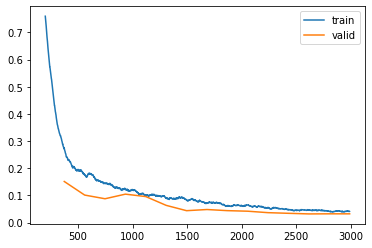

In [17]:
learn_18.recorder.plot_loss(skip_start=200)

In [18]:
learn_18.validate(dl=test_dl)

(#5) [0.02317519672214985,0.00712500000372529,0.9928749799728394,0.9928948688195088,0.992841703717251]

With no augmentation

| Metric | Value |
|--------|-----:|
| Error Rate | 0.008125 |
| Accuracy |0.991875|
| Precision | 0.991881|
| Recall | 0.991857|

With augmentation:

| Metric | Value |
|--------|-----:|
| Error Rate | 0.009125
| Accuracy | 0.990875
| Precision | 0.990880
| Recall | 0.990835

With augmentation and 16 epochs:

| Metric | Value |
|--------|-----:|
| Error Rate | 0.0078750001266599
| Accuracy | 0.9921249747276306
| Precision | 0.9921023548061928
| Recall | 0.9920582616376237

## Resnet 18  Untrained

In [19]:
learn_18_unt = cnn_learner(dls, 
                           resnet18, metrics=[error_rate, accuracy, precision, recall], 
                           pretrained=False
                           )

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.0010000000474974513)

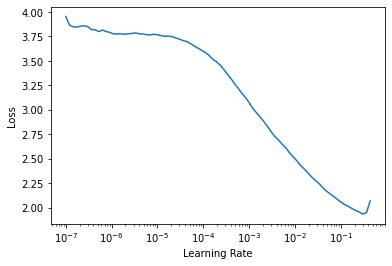

In [20]:
learn_18_unt.lr_find()

In [21]:
n = 18
lr = 1e-3
learn_18_unt.fit_one_cycle(n_epoch=n, lr_max=lr)

epoch,train_loss,valid_loss,error_rate,accuracy,precision_score,recall_score,time
0,0.835068,0.184415,0.055083,0.944917,0.944880,0.944813,00:49
1,0.288659,0.130021,0.035250,0.964750,0.965309,0.964479,00:49
2,0.182985,0.079939,0.024333,0.975667,0.976020,0.975685,00:49
3,0.152654,0.065051,0.018750,0.981250,0.981567,0.980982,00:49
4,0.111113,0.079734,0.022000,0.978000,0.978555,0.978041,00:49
5,0.095889,0.045100,0.012083,0.987917,0.987949,0.987812,00:49
6,0.084218,0.065483,0.018333,0.981667,0.982242,0.981418,00:49
7,0.069738,0.060384,0.016250,0.983750,0.983732,0.983648,00:49
8,0.059484,0.047831,0.012167,0.987833,0.988148,0.987649,00:49
9,0.046793,0.050626,0.015167,0.984833,0.984887,0.985129,00:49


Results without augmentation:

| epoch | train_loss | valid_loss | error_rate | accuracy | precision_score | recall_score | time  |
|-------|------------|------------|------------|----------|-----------------|--------------|-------|
| 0     | 0.281269   | 0.156072   | 0.046917   | 0.953083 | 0.954461        | 0.952646     | 00:51 |
| 1     | 0.112043   | 0.075744   | 0.022583   | 0.977417 | 0.977428        | 0.976989     | 00:51 |
| 2     | 0.078653   | 0.052826   | 0.014917   | 0.985083 | 0.985192        | 0.984778     | 00:51 |
| 3     | 0.060607   | 0.056665   | 0.015250   | 0.984750 | 0.985066        | 0.984336     | 00:51 |
| 4     | 0.042045   | 0.054098   | 0.015417   | 0.984583 | 0.984736        | 0.984505     | 00:51 |
| 5     | 0.027003   | 0.040291   | 0.010500   | 0.989500 | 0.989536        | 0.989372     | 00:51 |
| 6     | 0.011142   | 0.029470   | 0.007417   | 0.992583 | 0.992556        | 0.992548     | 00:51 |
| 7     | 0.005596   | 0.028730   | 0.007167   | 0.992833 | 0.992806        | 0.992759     | 00:51 |

Results with augmentation

| epoch | train_loss | valid_loss | error_rate | accuracy | precision_score | recall_score | time  |
|-------|------------|------------|------------|----------|-----------------|--------------|-------|
| 0     | 0.451950   | 0.293534   | 0.070167   | 0.929833 | 0.934617        | 0.930077     | 00:56 |
| 1     | 0.209920   | 0.157511   | 0.046417   | 0.953583 | 0.955947        | 0.953505     | 00:56 |
| 2     | 0.141694   | 0.171997   | 0.044833   | 0.955167 | 0.958470        | 0.954816     | 00:56 |
| 3     | 0.115787   | 0.105908   | 0.030500   | 0.969500 | 0.970300        | 0.969616     | 00:56 |
| 4     | 0.092771   | 0.051511   | 0.014583   | 0.985417 | 0.985440        | 0.985379     | 00:56 |
| 5     | 0.061399   | 0.037154   | 0.010917   | 0.989083 | 0.989066        | 0.989119     | 00:57 |
| 6     | 0.044307   | 0.026106   | 0.006750   | 0.993250 | 0.993149        | 0.993251     | 00:56 |
| 7     | 0.030072   | 0.023031   | 0.006000   | 0.994000 | 0.993958        | 0.993945     | 00:56 |

Results with new augmentation and 18 epochs

| epoch | train_loss | valid_loss | error_rate | accuracy | precision_score | recall_score | time  |
|-------|------------|------------|------------|----------|-----------------|--------------|-------|
| 0     | 0.659755   | 0.174646   | 0.047250   | 0.952750 | 0.952773        | 0.952780     | 00:53 |
| 1     | 0.268456   | 0.161001   | 0.042167   | 0.957833 | 0.958704        | 0.957887     | 00:53 |
| 2     | 0.182392   | 0.287995   | 0.070583   | 0.929417 | 0.938797        | 0.927216     | 00:53 |
| 3     | 0.150819   | 0.094501   | 0.026500   | 0.973500 | 0.973522        | 0.973528     | 00:54 |
| 4     | 0.121189   | 0.086677   | 0.023583   | 0.976417 | 0.977070        | 0.976204     | 00:53 |
| 5     | 0.100518   | 0.056162   | 0.013667   | 0.986333 | 0.986679        | 0.986248     | 00:53 |
| 6     | 0.094745   | 0.051414   | 0.014667   | 0.985333 | 0.985082        | 0.985539     | 00:52 |
| 7     | 0.074757   | 0.048140   | 0.014000   | 0.986000 | 0.985898        | 0.985928     | 00:52 |
| 8     | 0.061641   | 0.055585   | 0.016000   | 0.984000 | 0.984510        | 0.984470     | 00:51 |
| 9     | 0.059212   | 0.051380   | 0.013917   | 0.986083 | 0.986437        | 0.985770     | 00:50 |
| 10    | 0.047141   | 0.026911   | 0.007500   | 0.992500 | 0.992526        | 0.992463     | 00:50 |
| 11    | 0.042428   | 0.027038   | 0.007167   | 0.992833 | 0.992873        | 0.992847     | 00:50 |
| 12    | 0.031332   | 0.027396   | 0.007250   | 0.992750 | 0.992715        | 0.992759     | 00:50 |
| 13    | 0.027222   | 0.020967   | 0.004833   | 0.995167 | 0.995172        | 0.995150     | 00:50 |
| 14    | 0.022206   | 0.021710   | 0.005333   | 0.994667 | 0.994690        | 0.994670     | 00:51 |
| 15    | 0.019323   | 0.020594   | 0.004750   | 0.995250 | 0.995264        | 0.995244     | 00:52 |
| 16    | 0.016254   | 0.020436   | 0.004833   | 0.995167 | 0.995139        | 0.995184     | 00:52 |
| 17    | 0.015179   | 0.020070   | 0.005083   | 0.994917 | 0.994893        | 0.994907     | 00:51 |

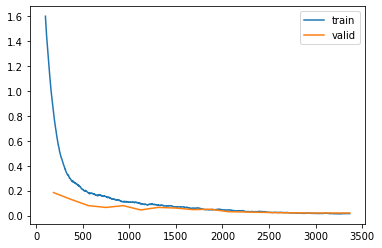

In [22]:
learn_18_unt.recorder.plot_loss(skip_start=100)

In [23]:
learn_18_unt.validate(dl=test_dl)

(#5) [0.015492078848183155,0.005125000141561031,0.9948750138282776,0.9949082616763805,0.9947544875152634]

Without augmentation:

| Metric | Value |
|--------|-----:|
| Error Rate | 0.0067500
| Accuracy | 0.9932500
| Precision | 0.9932891
| Recall | 0.9931777

With augmentation:

| Metric | Value |
|--------|-----:|
| Error Rate | 0.00587500
| Accuracy | 0.99412501
| Precision | 0.99412500
| Recall | 0.99403535

With new augmentation and 18 epochs:

| Metric | Value |
|--------|-----:|
| Error Rate | 0.0044999998062849
| Accuracy | 0.9955000281333923
| Precision | 0.9955036000697787
| Recall | 0.9954661203193798

##  Resnet 18 Untrained with many epochs

In [24]:
learn_18_unt_many = cnn_learner(dls, 
                                resnet18, metrics=[error_rate, accuracy, precision, recall], 
                                pretrained=False
                                )

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.0005754399462603033)

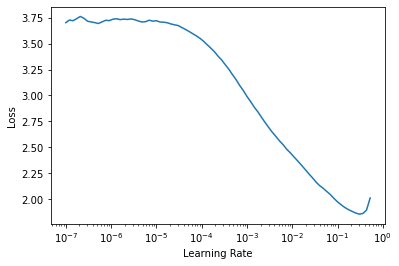

In [25]:
learn_18_unt_many.lr_find()

In [26]:
n = 60
lr = 1e-3
learn_18_unt_many.fit_one_cycle(n_epoch=n, lr_max=lr)

epoch,train_loss,valid_loss,error_rate,accuracy,precision_score,recall_score,time
0,1.015889,0.268221,0.082917,0.917083,0.917020,0.917072,00:49
1,0.454086,0.143133,0.039667,0.960333,0.959907,0.960362,00:49
2,0.266377,0.096470,0.028333,0.971667,0.971212,0.971731,00:49
3,0.194291,0.088706,0.024083,0.975917,0.976149,0.975832,00:49
4,0.156337,0.080079,0.021833,0.978167,0.978186,0.978292,00:49
5,0.137038,0.066593,0.018500,0.981500,0.981442,0.981431,00:49
6,0.116504,0.069879,0.019417,0.980583,0.980606,0.980601,00:49
7,0.101958,0.070880,0.021083,0.978917,0.979209,0.978912,00:49
8,0.098011,0.084072,0.024917,0.975083,0.976350,0.974713,00:49
9,0.086610,0.050773,0.015083,0.984917,0.984997,0.985063,00:49




Results with new augmentation and 60 epochs

| epoch | train_loss | valid_loss | error_rate | accuracy | precision_score | recall_score | time  |
|-------|------------|------------|------------|----------|-----------------|--------------|-------|
| 0     | 1.015889   | 0.268221   | 0.082917   | 0.917083 | 0.917020        | 0.917072     | 00:49 |
| 1     | 0.454086   | 0.143133   | 0.039667   | 0.960333 | 0.959907        | 0.960362     | 00:49 |
| 2     | 0.266377   | 0.096470   | 0.028333   | 0.971667 | 0.971212        | 0.971731     | 00:49 |
| 3     | 0.194291   | 0.088706   | 0.024083   | 0.975917 | 0.976149        | 0.975832     | 00:49 |
| 4     | 0.156337   | 0.080079   | 0.021833   | 0.978167 | 0.978186        | 0.978292     | 00:49 |
| 5     | 0.137038   | 0.066593   | 0.018500   | 0.981500 | 0.981442        | 0.981431     | 00:49 |
| 6     | 0.116504   | 0.069879   | 0.019417   | 0.980583 | 0.980606        | 0.980601     | 00:49 |
| 7     | 0.101958   | 0.070880   | 0.021083   | 0.978917 | 0.979209        | 0.978912     | 00:49 |
| 8     | 0.098011   | 0.084072   | 0.024917   | 0.975083 | 0.976350        | 0.974713     | 00:49 |
| 9     | 0.086610   | 0.050773   | 0.015083   | 0.984917 | 0.984997        | 0.985063     | 00:49 |
| 10    | 0.078013   | 0.052740   | 0.014333   | 0.985667 | 0.985809        | 0.985619     | 00:49 |
| 11    | 0.077414   | 0.053417   | 0.012667   | 0.987333 | 0.987706        | 0.987191     | 00:49 |
| 12    | 0.065726   | 0.045654   | 0.012333   | 0.987667 | 0.987748        | 0.987620     | 00:49 |
| 13    | 0.064223   | 0.056095   | 0.016333   | 0.983667 | 0.983573        | 0.983680     | 00:49 |
| 14    | 0.055292   | 0.045665   | 0.012333   | 0.987667 | 0.987748        | 0.987454     | 00:49 |
| 15    | 0.056001   | 0.031684   | 0.009083   | 0.990917 | 0.991036        | 0.990857     | 00:48 |
| 16    | 0.053419   | 0.043852   | 0.012917   | 0.987083 | 0.987146        | 0.987127     | 00:49 |
| 17    | 0.042880   | 0.046079   | 0.011333   | 0.988667 | 0.988774        | 0.988669     | 00:49 |
| 18    | 0.046384   | 0.028290   | 0.007833   | 0.992167 | 0.992143        | 0.992137     | 00:48 |
| 19    | 0.044465   | 0.025235   | 0.007583   | 0.992417 | 0.992438        | 0.992347     | 00:49 |
| 20    | 0.038581   | 0.031111   | 0.008583   | 0.991417 | 0.991545        | 0.991281     | 00:49 |
| 21    | 0.038182   | 0.025441   | 0.006167   | 0.993833 | 0.993751        | 0.993873     | 00:49 |
| 22    | 0.033787   | 0.026671   | 0.007583   | 0.992417 | 0.992448        | 0.992405     | 00:48 |
| 23    | 0.029534   | 0.029242   | 0.007333   | 0.992667 | 0.992795        | 0.992631     | 00:48 |
| 24    | 0.032679   | 0.031591   | 0.008333   | 0.991667 | 0.991785        | 0.991563     | 00:49 |
| 25    | 0.029756   | 0.028661   | 0.007917   | 0.992083 | 0.992177        | 0.992044     | 00:48 |
| 26    | 0.028311   | 0.025895   | 0.006667   | 0.993333 | 0.993350        | 0.993350     | 00:48 |
| 27    | 0.027028   | 0.022575   | 0.006167   | 0.993833 | 0.993812        | 0.993804     | 00:48 |
| 28    | 0.027942   | 0.018996   | 0.005083   | 0.994917 | 0.994915        | 0.994842     | 00:49 |
| 29    | 0.024762   | 0.026721   | 0.006750   | 0.993250 | 0.993270        | 0.993223     | 00:49 |
| 30    | 0.024846   | 0.019864   | 0.005333   | 0.994667 | 0.994697        | 0.994557     | 00:49 |
| 31    | 0.024689   | 0.019097   | 0.004917   | 0.995083 | 0.995092        | 0.995051     | 00:49 |
| 32    | 0.021769   | 0.024939   | 0.006500   | 0.993500 | 0.993478        | 0.993499     | 00:48 |
| 33    | 0.020251   | 0.023109   | 0.005333   | 0.994667 | 0.994744        | 0.994607     | 00:48 |
| 34    | 0.020256   | 0.021377   | 0.005167   | 0.994833 | 0.994855        | 0.994760     | 00:49 |
| 35    | 0.016879   | 0.021555   | 0.005000   | 0.995000 | 0.994998        | 0.994988     | 00:48 |
| 36    | 0.015424   | 0.021788   | 0.005250   | 0.994750 | 0.994808        | 0.994650     | 00:48 |
| 37    | 0.014975   | 0.023143   | 0.005417   | 0.994583 | 0.994604        | 0.994546     | 00:49 |
| 38    | 0.014907   | 0.023164   | 0.004833   | 0.995167 | 0.995188        | 0.995133     | 00:48 |
| 39    | 0.013542   | 0.023273   | 0.006250   | 0.993750 | 0.993655        | 0.993744     | 00:48 |
| 40    | 0.013206   | 0.022767   | 0.005167   | 0.994833 | 0.994846        | 0.994761     | 00:49 |
| 41    | 0.011779   | 0.019282   | 0.004250   | 0.995750 | 0.995769        | 0.995684     | 00:49 |
| 42    | 0.011472   | 0.021201   | 0.004833   | 0.995167 | 0.995204        | 0.995090     | 00:48 |
| 43    | 0.011113   | 0.021367   | 0.004333   | 0.995667 | 0.995680        | 0.995579     | 00:49 |
| 44    | 0.009246   | 0.019994   | 0.004750   | 0.995250 | 0.995229        | 0.995246     | 00:48 |
| 45    | 0.011497   | 0.023947   | 0.005250   | 0.994750 | 0.994787        | 0.994708     | 00:48 |
| 46    | 0.009922   | 0.021290   | 0.004333   | 0.995667 | 0.995681        | 0.995630     | 00:48 |
| 47    | 0.009775   | 0.020818   | 0.004667   | 0.995333 | 0.995361        | 0.995281     | 00:49 |
| 48    | 0.007924   | 0.020002   | 0.003667   | 0.996333 | 0.996354        | 0.996314     | 00:48 |
| 49    | 0.008250   | 0.019710   | 0.004083   | 0.995917 | 0.995915        | 0.995892     | 00:49 |
| 50    | 0.007181   | 0.019610   | 0.004750   | 0.995250 | 0.995290        | 0.995233     | 00:49 |
| 51    | 0.007415   | 0.018970   | 0.004000   | 0.996000 | 0.996008        | 0.995968     | 00:48 |
| 52    | 0.006258   | 0.019281   | 0.004250   | 0.995750 | 0.995762        | 0.995731     | 00:49 |
| 53    | 0.006884   | 0.019844   | 0.004167   | 0.995833 | 0.995846        | 0.995790     | 00:48 |
| 54    | 0.005536   | 0.019556   | 0.004333   | 0.995667 | 0.995683        | 0.995614     | 00:48 |
| 55    | 0.004957   | 0.019238   | 0.003750   | 0.996250 | 0.996258        | 0.996204     | 00:49 |
| 56    | 0.005305   | 0.019297   | 0.004167   | 0.995833 | 0.995844        | 0.995788     | 00:49 |
| 57    | 0.005733   | 0.019186   | 0.004250   | 0.995750 | 0.995765        | 0.995696     | 00:48 |
| 58    | 0.003913   | 0.019329   | 0.003917   | 0.996083 | 0.996088        | 0.996030     | 00:49 |
| 59    | 0.005088   | 0.019332   | 0.003917   | 0.996083 | 0.996097        | 0.996035     | 00:49 |

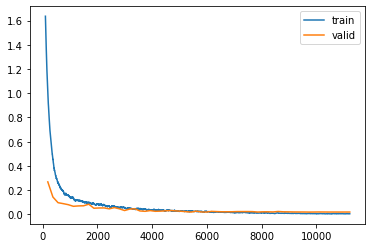

In [27]:
learn_18_unt_many.recorder.plot_loss(skip_start=100)

In [28]:
learn_18_unt_many.validate(dl=test_dl)

(#5) [0.013725641183555126,0.004625000059604645,0.9953749775886536,0.9954181197041052,0.9952767627681027]

With new augmentation and 60 epochs:

| Metric | Value |
|--------|-----:|
| Error Rate | 0.0046250000596046
| Accuracy | 0.9953749775886536
| Precision | 0.9954181197041052
| Recall | 0.9952767627681027]

## Resnet 34 Pretrained

In [ ]:
learn_34 = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy, precision, recall], pretrained=True)

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.013182567432522774)

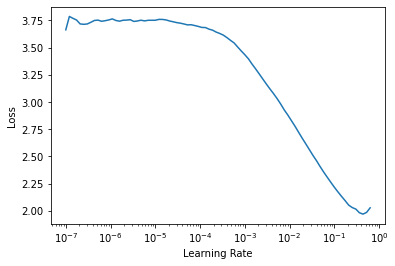

In [ ]:
learn_34.lr_find()

In [ ]:
n = 8
lr = 1e-2
learn_34.fit_one_cycle(n_epoch=n, lr_max=lr)

epoch,train_loss,valid_loss,error_rate,accuracy,precision_score,recall_score,time
0,0.368139,0.167955,0.050250,0.949750,0.950084,0.949740,00:56
1,0.127198,0.129974,0.037500,0.962500,0.964245,0.961122,00:55
2,0.089532,0.125045,0.034750,0.965250,0.966986,0.964015,00:56
3,0.068741,0.072835,0.021833,0.978167,0.978542,0.978169,00:55
4,0.048072,0.049588,0.013083,0.986917,0.987393,0.986802,00:56
5,0.031072,0.038731,0.009083,0.990917,0.991010,0.990727,00:56
6,0.017881,0.031832,0.007750,0.992250,0.992271,0.992135,00:56
7,0.011673,0.030884,0.007167,0.992833,0.992831,0.992728,00:55


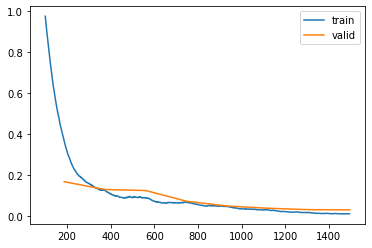

In [ ]:
learn_34.recorder.plot_loss(skip_start=100)

In [ ]:
learn_34.validate(dl=test_dl)

(#5) [0.021880125626921654,0.00787500012665987,0.9921249747276306,0.9921124563875956,0.9920476920599901]

| Metric | Value |
|--------|-----:|
| Error Rate | 0.00787500
| Accuracy | 0.99212497
| Precision | 0.99211246
| Recall | 0.99204769

In [ ]:
learn_34.unfreeze()

SuggestedLRs(lr_min=9.12010818865383e-08, lr_steep=3.981071586167673e-06)

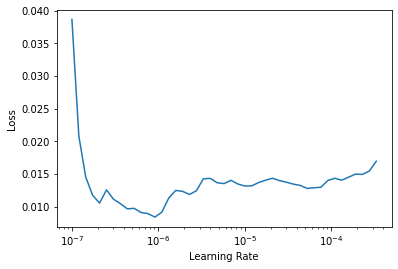

In [ ]:
learn_34.lr_find()

In [ ]:
n = 10
lr = 5e-7
learn_34.fit_one_cycle(n_epoch=n, lr_max=lr)

epoch,train_loss,valid_loss,error_rate,accuracy,precision_score,recall_score,time
0,0.009512,0.030438,0.006917,0.993083,0.993099,0.992969,01:00
1,0.009969,0.030400,0.007333,0.992667,0.992706,0.992521,00:58
2,0.010843,0.030063,0.006833,0.993167,0.993175,0.993063,00:59
3,0.009818,0.030025,0.007000,0.993000,0.993010,0.992887,00:59
4,0.008848,0.030471,0.007083,0.992917,0.992932,0.992816,00:59
5,0.008581,0.030649,0.007250,0.992750,0.992786,0.992606,00:58
6,0.008628,0.030191,0.007250,0.992750,0.992784,0.992632,00:59
7,0.008571,0.030379,0.006833,0.993167,0.993189,0.993030,00:59
8,0.007604,0.030400,0.007083,0.992917,0.992955,0.992764,00:59
9,0.009241,0.030837,0.006917,0.993083,0.993147,0.992917,00:58


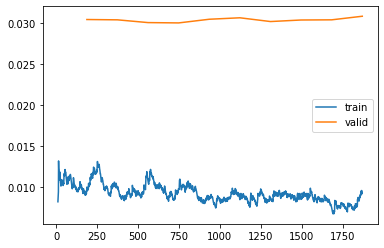

In [ ]:
learn_34.recorder.plot_loss(skip_start=10)

In [ ]:
learn_34.validate(dl=test_dl)

(#5) [0.020970115438103676,0.007249999791383743,0.9927499890327454,0.992786805523178,0.9926656570580338]

| Metric | Value |
|--------|-----:|
| Error Rate | 0.00787500
| Accuracy | 0.99212497
| Precision | 0.99211246
| Recall | 0.99204769

## Resnet 34 Untrained

In [ ]:
learn_34_unt = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy, precision, recall], pretrained=False)

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=0.005248074419796467)

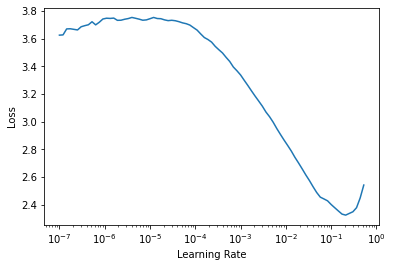

In [ ]:
learn_34_unt.lr_find()

In [ ]:
n = 24
lr = 5e-3
learn_34_unt.fit_one_cycle(n_epoch=n, lr_max=lr)

epoch,train_loss,valid_loss,error_rate,accuracy,precision_score,recall_score,time
0,0.515565,0.136509,0.041333,0.958667,0.959263,0.958746,00:56
1,0.251357,0.128459,0.034083,0.965917,0.966326,0.966210,00:54
2,0.186521,0.362475,0.094667,0.905333,0.913388,0.903235,00:54
3,0.172923,0.196145,0.047333,0.952667,0.954186,0.954023,00:54
4,0.145006,0.398719,0.101083,0.898917,0.920162,0.901175,00:54
5,0.129771,0.157840,0.035500,0.964500,0.968482,0.963662,00:54
6,0.105848,0.089481,0.021333,0.978667,0.979214,0.978695,00:54
7,0.086850,0.054469,0.013000,0.987000,0.987079,0.986896,00:54
8,0.080098,0.068752,0.021833,0.978167,0.979226,0.978142,00:54
9,0.066850,0.053336,0.013917,0.986083,0.986437,0.985612,00:54


Results witout augmentation:

| epoch | train_loss | valid_loss | error_rate | accuracy | precision_score | recall_score | time  |
|-------|------------|------------|------------|----------|-----------------|--------------|-------|
| 0     | 0.039619   | 0.112828   | 0.030000   | 0.970000 | 0.971269        | 0.970083     | 00:55 |
| 1     | 0.064647   | 0.080043   | 0.021500   | 0.978500 | 0.978347        | 0.978670     | 00:55 |
| 2     | 0.047435   | 0.054005   | 0.014250   | 0.985750 | 0.985919        | 0.985624     | 00:55 |
| 3     | 0.039049   | 0.062228   | 0.014083   | 0.985917 | 0.986261        | 0.985824     | 00:55 |
| 4     | 0.022147   | 0.028577   | 0.007667   | 0.992333 | 0.992278        | 0.992295     | 00:55 |
| 5     | 0.011803   | 0.025830   | 0.006583   | 0.993417 | 0.993452        | 0.993354     | 00:55 |
| 6     | 0.006023   | 0.026232   | 0.005667   | 0.994333 | 0.994374        | 0.994267     | 00:55 |
| 7     | 0.002737   | 0.024292   | 0.005583   | 0.994417 | 0.994437        | 0.994346     | 00:55 |

Results with augmentation:

| epoch | train_loss | valid_loss | error_rate | accuracy | precision_score | recall_score | time  |
|-------|------------|------------|------------|----------|-----------------|--------------|-------|
| 0     | 0.419716   | 0.214317   | 0.060583   | 0.939417 | 0.942483        | 0.938733     | 01:00 |
| 1     | 0.216846   | 0.299122   | 0.071500   | 0.928500 | 0.934034        | 0.927810     | 01:00 |
| 2     | 0.151916   | 0.144922   | 0.037583   | 0.962417 | 0.963831        | 0.962474     | 01:00 |
| 3     | 0.130369   | 0.160243   | 0.040667   | 0.959333 | 0.961333        | 0.959479     | 00:59 |
| 4     | 0.105945   | 0.053418   | 0.014750   | 0.985250 | 0.985487        | 0.984934     | 00:59 |
| 5     | 0.069260   | 0.056563   | 0.015500   | 0.984500 | 0.984772        | 0.984540     | 00:59 |
| 6     | 0.043437   | 0.025455   | 0.006833   | 0.993167 | 0.993140        | 0.993200     | 00:59 |
| 7     | 0.035656   | 0.021499   | 0.006000   | 0.994000 | 0.993988        | 0.994029     | 00:59 |


Results with augmentation:

| epoch | train_loss | valid_loss | error_rate | accuracy | precision_score | recall_score | time  |
|-------|------------|------------|------------|----------|-----------------|--------------|-------|
| 0     | 0.434923   | 0.204655   | 0.056417   | 0.943583 | 0.948386        | 0.943349     | 01:00 |
| 1     | 0.203476   | 0.492449   | 0.142417   | 0.857583 | 0.897650        | 0.858080     | 01:00 |
| 2     | 0.181186   | 0.173188   | 0.041250   | 0.958750 | 0.959990        | 0.959058     | 01:00 |
| 3     | 0.141588   | 0.228250   | 0.066500   | 0.933500 | 0.939748        | 0.933744     | 00:59 |
| 4     | 0.122586   | 0.083044   | 0.024917   | 0.975083 | 0.975605        | 0.975126     | 01:00 |
| 5     | 0.100340   | 0.081758   | 0.023833   | 0.976167 | 0.976255        | 0.976230     | 00:59 |
| 6     | 0.080325   | 0.042493   | 0.011833   | 0.988167 | 0.988165        | 0.988201     | 00:59 |
| 7     | 0.065300   | 0.050322   | 0.013750   | 0.986250 | 0.986360        | 0.986087     | 00:59 |
| 8     | 0.048775   | 0.033287   | 0.009667   | 0.990333 | 0.990488        | 0.990173     | 00:59 |
| 9     | 0.035085   | 0.023485   | 0.006833   | 0.993167 | 0.993230        | 0.993121     | 00:59 |
| 10    | 0.025312   | 0.020328   | 0.005917   | 0.994083 | 0.994074        | 0.994052     | 00:59 |
| 11    | 0.024283   | 0.019765   | 0.005500   | 0.994500 | 0.994496        | 0.994458     | 01:00 |

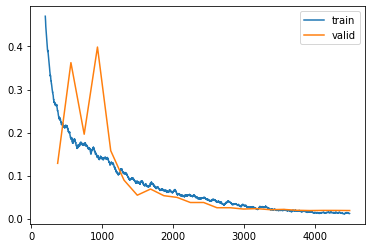

In [ ]:
learn_34_unt.recorder.plot_loss(skip_start=200)

In [ ]:
learn_34_unt.validate(dl=test_dl)

(#5) [0.012356985360383987,0.0042500002309679985,0.9957500100135803,0.9957554346155162,0.9956717066977608]

Without augmentation

| Metric | Value |
|--------|-----:|
| Error Rate | 0.005250
| Accuracy | 0.994750
| Precision | 0.994779
| Recall | 0.994746


With augmentation (12 epoch)

| Metric | Value |
|--------|-----:|
| Error Rate | 0.00550000
| Accuracy | 0.99450000
| Precision | 0.99450272
| Recall | 0.99440652

SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=1.9054607491852948e-06)

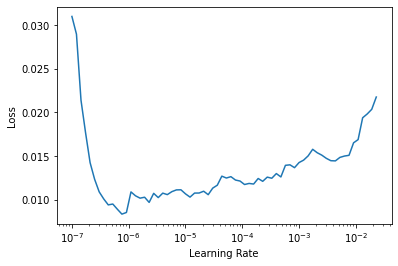

In [ ]:
learn_34_unt.lr_find()

In [ ]:
n = 12
lr = 5e-8
learn_34_unt.fit_one_cycle(n_epoch=n, lr_max=lr)

epoch,train_loss,valid_loss,error_rate,accuracy,precision_score,recall_score,time
0,0.011154,0.019019,0.004417,0.995583,0.995595,0.995541,00:56
1,0.013118,0.018857,0.004667,0.995333,0.995347,0.995291,00:55
2,0.014333,0.018867,0.004833,0.995167,0.995173,0.995128,00:55
3,0.012505,0.018873,0.004750,0.995250,0.995262,0.995208,00:54
4,0.011070,0.019093,0.004917,0.995083,0.995095,0.995042,00:54
5,0.011414,0.018728,0.004750,0.995250,0.995253,0.995202,00:54
6,0.012782,0.019049,0.004750,0.995250,0.995256,0.995206,00:55
7,0.012560,0.018834,0.004833,0.995167,0.995186,0.995128,00:55
8,0.012998,0.018819,0.004917,0.995083,0.995091,0.995043,00:54
9,0.011139,0.018946,0.004833,0.995167,0.995165,0.995126,00:54


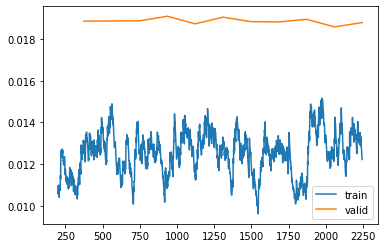

In [ ]:
learn_34_unt.recorder.plot_loss(skip_start=200)

In [ ]:
learn_34_unt.validate(dl=test_dl)

(#5) [0.01196974329650402,0.004124999977648258,0.9958750009536743,0.9958789114939751,0.9957967066977609]

With augmentation (12 additional epochs)

| Metric | Value |
|--------|-----:|
| Error Rate | 0.00500000
| Accuracy | 0.99500000
| Precision | 0.99498937
| Recall | 0.99491510

With new augmentation (12 additional epochs)

| Metric | Value |
|--------|-----:|
| Error Rate | 0.0041249999776483
| Accuracy | 0.9958750009536743
| Precision | 0.9958789114939751
| Recall | 0.9957967066977609

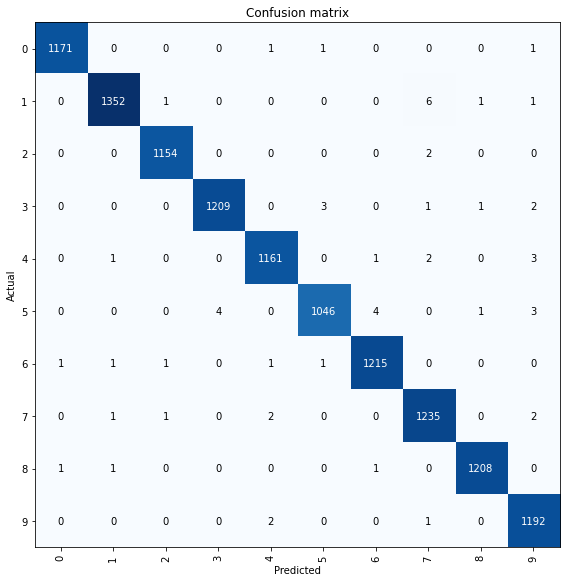

In [ ]:
interp_34_unt = ClassificationInterpretation.from_learner(learn_34_unt)
interp_34_unt.plot_confusion_matrix(figsize=(8,8))

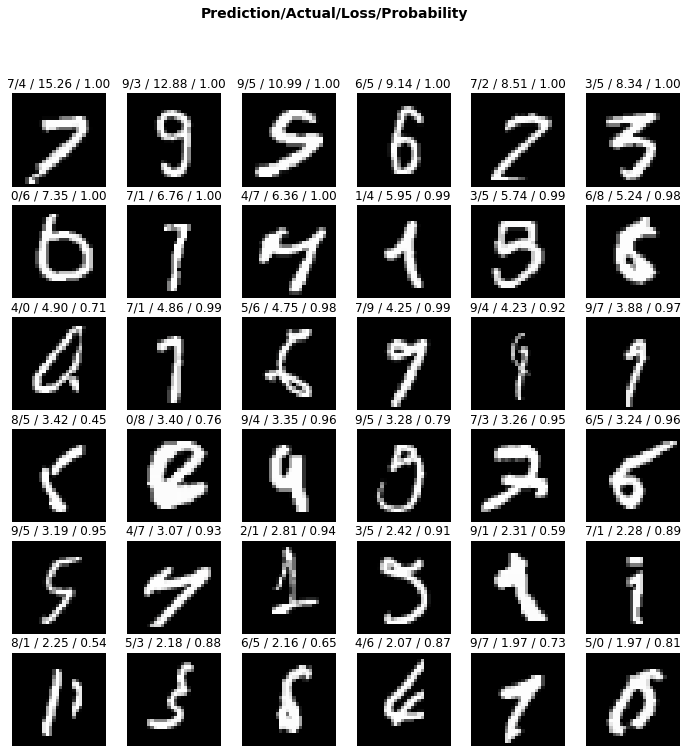

In [ ]:
# interp_34_unt.most_confused()
interp_34_unt.plot_top_losses(k=36, figsize=(12,12))

## Resnet 34, augmentation, mixup and label smoothing

- `loss_funct=LabelSmoothingCrossEntropy()`
- `cbs=MixUp()`

In [ ]:
learn_34_unt = cnn_learner(dls, 
                           resnet34, 
                           metrics=[error_rate, accuracy, precision, recall], 
                           loss_func=LabelSmoothingCrossEntropy(),
                           pretrained=False)

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.002511886414140463)

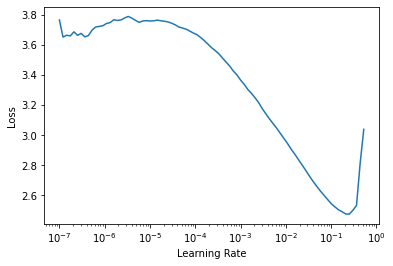

In [ ]:
learn_34_unt.lr_find()

In [ ]:
n = 24
lr = 3e-3
learn_34_unt.fit_one_cycle(n_epoch=n, lr_max=lr)

epoch,train_loss,valid_loss,error_rate,accuracy,precision_score,recall_score,time
0,1.253471,0.832205,0.059333,0.940667,0.940963,0.940473,00:54
1,0.789759,0.786159,0.040083,0.959917,0.960096,0.959997,00:54
2,0.703194,0.664675,0.034417,0.965583,0.966947,0.965417,00:54
3,0.678863,0.617888,0.043500,0.956500,0.959818,0.955629,00:54
4,0.642244,0.598000,0.023833,0.976167,0.976711,0.975915,00:54
5,0.636750,4.170094,0.154833,0.845167,0.883031,0.856060,00:54
6,0.604441,0.701063,0.018333,0.981667,0.981707,0.981736,00:54
7,0.588152,0.592750,0.017250,0.982750,0.982589,0.982919,00:54
8,0.584477,0.558336,0.022583,0.977417,0.977926,0.977069,00:54
9,0.592424,0.538465,0.010917,0.989083,0.989127,0.988964,00:54


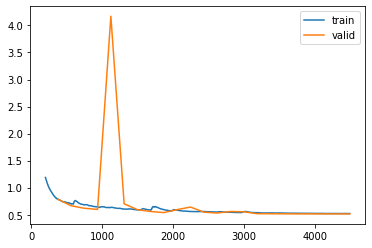

In [ ]:
learn_34_unt.recorder.plot_loss(skip_start=200)

In [ ]:
learn_34_unt.validate(dl=test_dl)

(#5) [0.5108846426010132,0.004124999977648258,0.9958750009536743,0.9959060072254967,0.9958074547652199]

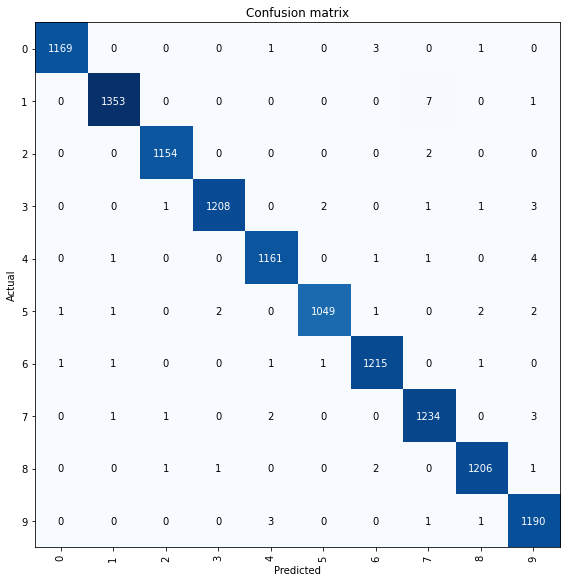

In [ ]:
interp_34_unt = ClassificationInterpretation.from_learner(learn_34_unt)
interp_34_unt.plot_confusion_matrix(figsize=(8,8))

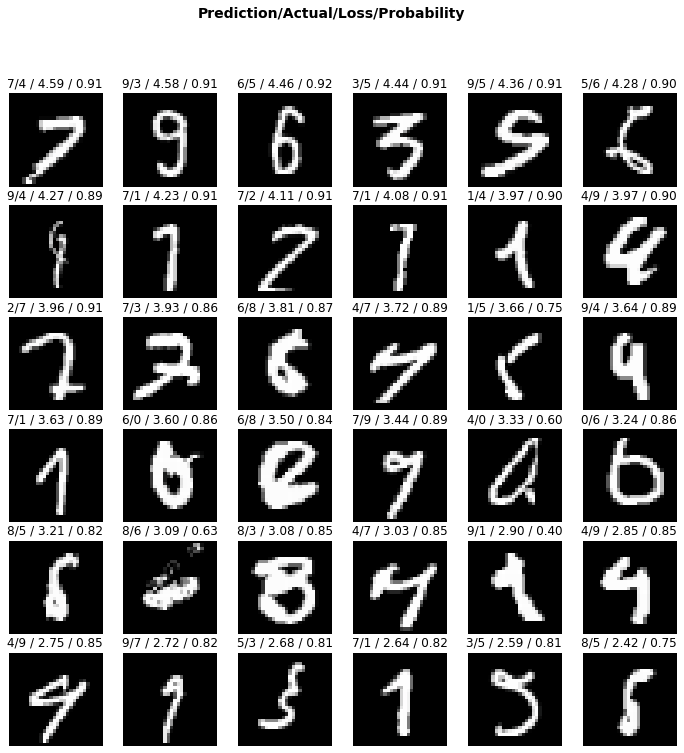

In [ ]:
interp_34_unt.plot_top_losses(k=36, figsize=(12,12))

In [ ]:
learn_34_unt_mx = cnn_learner(dls, 
                           resnet34, 
                           metrics=[error_rate, accuracy, precision, recall], 
                           cbs=MixUp(),
                           pretrained=False)

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.033113110810518265)

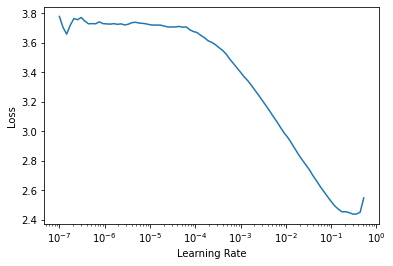

In [ ]:
learn_34_unt_mx.lr_find()

In [ ]:
n = 60
lr = 5e-3
learn_34_unt_mx.fit_one_cycle(n_epoch=n, lr_max=lr)

epoch,train_loss,valid_loss,error_rate,accuracy,precision_score,recall_score,time
0,0.848369,0.184744,0.051667,0.948333,0.948281,0.948056,00:55
1,0.507838,0.144775,0.038167,0.961833,0.962355,0.961724,00:54
2,0.391184,0.142673,0.036750,0.963250,0.964517,0.963497,00:55
3,0.341349,0.197894,0.056750,0.943250,0.949271,0.944588,00:55
4,0.311386,0.152140,0.041583,0.958417,0.959941,0.957802,00:55
5,0.295840,0.112466,0.029250,0.970750,0.971154,0.971208,00:55
6,0.262499,0.056660,0.015417,0.984583,0.984339,0.984748,00:55
7,0.253591,0.200834,0.060167,0.939833,0.949997,0.940608,00:55
8,0.231237,0.083891,0.020417,0.979583,0.980004,0.979298,00:55
9,0.217871,0.380141,0.106250,0.893750,0.925806,0.896134,00:55


| epoch | train_loss | valid_loss | error_rate | accuracy | precision_score | recall_score | time  |
|-------|------------|------------|------------|----------|-----------------|--------------|-------|
| 0     | 0.659755   | 0.174646   | 0.047250   | 0.952750 | 0.952773        | 0.952780     | 00:53 |
| 1     | 0.268456   | 0.161001   | 0.042167   | 0.957833 | 0.958704        | 0.957887     | 00:53 |
| 2     | 0.182392   | 0.287995   | 0.070583   | 0.929417 | 0.938797        | 0.927216     | 00:53 |
| 3     | 0.150819   | 0.094501   | 0.026500   | 0.973500 | 0.973522        | 0.973528     | 00:54 |
| 4     | 0.121189   | 0.086677   | 0.023583   | 0.976417 | 0.977070        | 0.976204     | 00:53 |
| 5     | 0.100518   | 0.056162   | 0.013667   | 0.986333 | 0.986679        | 0.986248     | 00:53 |
| 6     | 0.094745   | 0.051414   | 0.014667   | 0.985333 | 0.985082        | 0.985539     | 00:52 |
| 7     | 0.074757   | 0.048140   | 0.014000   | 0.986000 | 0.985898        | 0.985928     | 00:52 |
| 8     | 0.061641   | 0.055585   | 0.016000   | 0.984000 | 0.984510        | 0.984470     | 00:51 |
| 9     | 0.059212   | 0.051380   | 0.013917   | 0.986083 | 0.986437        | 0.985770     | 00:50 |
| 10    | 0.047141   | 0.026911   | 0.007500   | 0.992500 | 0.992526        | 0.992463     | 00:50 |
| 11    | 0.042428   | 0.027038   | 0.007167   | 0.992833 | 0.992873        | 0.992847     | 00:50 |
| 12    | 0.031332   | 0.027396   | 0.007250   | 0.992750 | 0.992715        | 0.992759     | 00:50 |
| 13    | 0.027222   | 0.020967   | 0.004833   | 0.995167 | 0.995172        | 0.995150     | 00:50 |
| 14    | 0.022206   | 0.021710   | 0.005333   | 0.994667 | 0.994690        | 0.994670     | 00:51 |
| 15    | 0.019323   | 0.020594   | 0.004750   | 0.995250 | 0.995264        | 0.995244     | 00:52 |
| 16    | 0.016254   | 0.020436   | 0.004833   | 0.995167 | 0.995139        | 0.995184     | 00:52 |
| 17    | 0.015179   | 0.020070   | 0.005083   | 0.994917 | 0.994893        | 0.994907     | 00:51 |

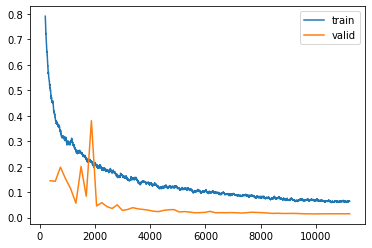

In [ ]:
learn_34_unt_mx.recorder.plot_loss(skip_start=200)

In [ ]:
learn_34_unt_mx.validate(dl=test_dl)

(#5) [0.010135658085346222,0.003000000026077032,0.996999979019165,0.9970266625320281,0.9969815986647411]

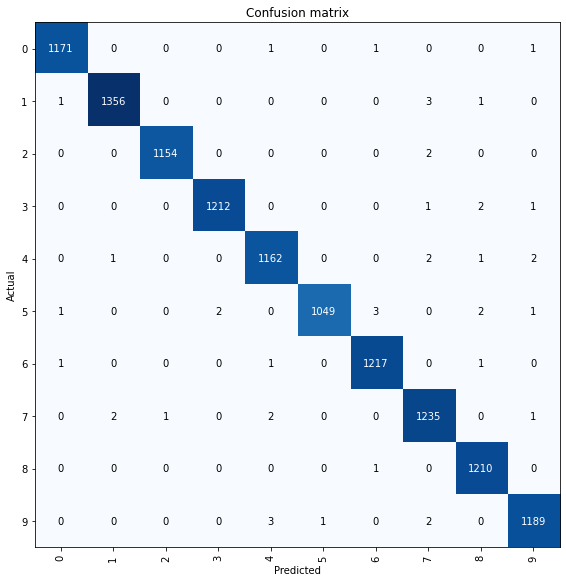

In [ ]:
interp_34_unt_mx = ClassificationInterpretation.from_learner(learn_34_unt_mx)
interp_34_unt_mx.plot_confusion_matrix(figsize=(8,8))

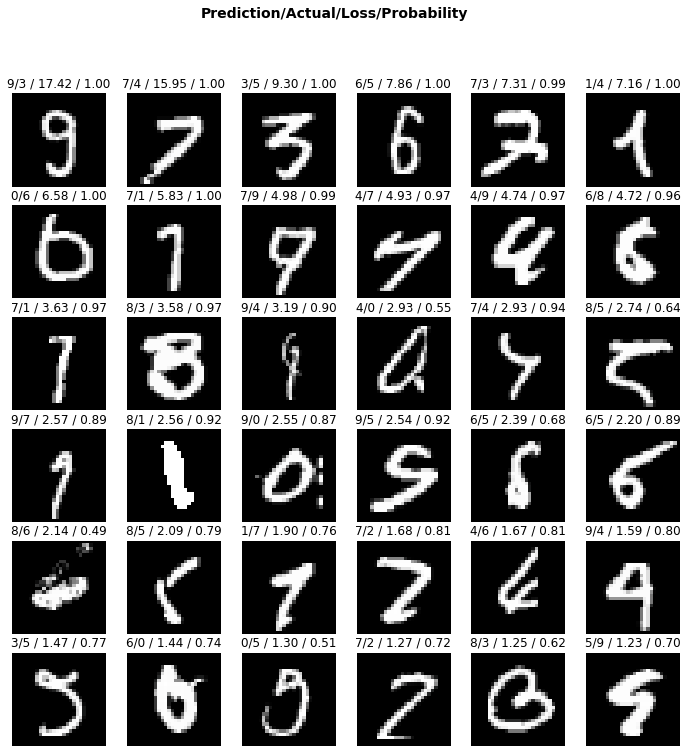

In [ ]:
interp_34_unt_mx.plot_top_losses(k=36, figsize=(12,12))